# SNAPI Overview

SNAPI (Supernova API) is a Python package designed to simplify import and manipulation of transient data from a variety of sources and modalities. SNAPI also provides an API for light curve fitting, and an interface for generating consistent and high-quality data plots.

Here, we will go through a few examples of how SNAPI can be used to simplify transient workflows.

## Example 1: Aggregating and displaying information about 2023ixf
In SNAPI, information about a transient is stored as a Transient object. Transient objects have the following attributes:
* 'id': the transient identifier. Defaults to a TNS/IAU name if provided, but can also be an instrument-specific name.
* 'coordinates': an astropy SkyCoord representing the location of the transient in the sky. Assumes stationarity (aka. not NEUs or other moving objects).
* 'redshift': the redshift of the transient, if available. Currently only queries spectroscopic redshifts.
* 'internal_names': a set of other names that represent the same transient. For example, can contain ZTF or ANTARES names. Queries of the transient will check all internal names.
* 'photometry': a Photometry object containing all light curves associated with the transient.
* 'spectroscopy': a Spectroscopy object containing all spectra associated with the transient.
* 'spec_class': the spectroscopic classification of the transient, if available.

In this example, we will show how to aggregate information about 2023ixf from multiple online databases from just its IAU name.

First, let's create a Transient object for 2023ixf. This object will only have a non-empty 'id' field:

In [17]:
from snapi import Transient

ixf_transient = Transient(iid="2023ixf")
print(ixf_transient.id)
print(ixf_transient.coordinates)

2023ixf
None


Next, we will populate this Transient object from results of multiple queries to data brokers (stored as a QueryResult for each query). Currently, the following QueryAgent classes are implemented:
* TNSQueryAgent: useful for retrieving coordinates, redshift, spectroscopic class, spectra, and alternate identifiers. Has limited photometry. Requires API keys in local environment.
* ALeRCEQueryAgent: retrieves photometry, but requires a ZTF internal name to be in the Transient object. Therefore, I recommend querying TNS first if using an IAU identifier. Includes forced photometry if using custom alerce_client repository.
* ANTARESQueryAgent: also retrieves photometry that SHOULD match ALeRCE's but without forced photometry. I've seen cases where they have not been identical. Also requires a ZTF- or ANT- internal name.
* GHOSTQueryAgent: for host galaxy querying. Not yet integrated into the Transient object framework.

QueryAgents in progress:
* YSEQueryAgent: to retrieve information from the Young Supernova Experiment databases, which uses Pan-STARRS photometry.
* ATLASQueryAgent: to retrieve photometry from ATLAS, a southern hemisphere telescope.

To use a QueryAgent, we first instantiate a QueryAgent object, and then run its query_transient() function with the transient object as input. This will automatically try:
(1) Querying the 'id' and each name in 'internal_names' sequentially for matches.
(2) Doing a cone search based on 'coordinates', if not empty. Only implemented for TNS and ANTARES.

The output of query_transient() is a list of QueryResults and a boolean stating if a match was found. We can then convert each QueryResult object to a dictionary using to_dict(), and then save that dictionary's contents to the transient by using the transient's "ingest_query_info()" function. This will automatically handle:
* Merging light curves from the same filter/instrument without repeats.
* Only overriding transient attributes if they were previously null.
* Adding any yet undiscovered internal names.


In [18]:
from snapi.query_agents import TNSQueryAgent, ALeRCEQueryAgent, ANTARESQueryAgent

tns_query_agent = TNSQueryAgent()
alerce_query_agent = ALeRCEQueryAgent()
antares_agent = ANTARESQueryAgent()

for agent in [tns_query_agent, alerce_query_agent, antares_agent]:
    query_results, _ = agent.query_transient(ixf_transient)
    for query_result in query_results:
        ixf_transient.ingest_query_info(query_result.to_dict())
    print(ixf_transient.internal_names)

{'ZTF23aaklqou', 'PS23dij', 'MASTER OT J140338.55+541840.8', 'ATLAS23ncx', 'MASTER OT J140338.60+541842.0'}
{'ZTF23aaklqou', 'PS23dij', 'MASTER OT J140338.55+541840.8', 'ATLAS23ncx', 'MASTER OT J140338.60+541842.0'}
{'ZTF23aaklqou', 'PS23dij', 'MASTER OT J140338.55+541840.8', 'ATLAS23ncx', 'MASTER OT J140338.60+541842.0', 'ANT2023l4lgj6bhp4rt'}


Let's now see what information is saved to the 2023ixf Transient object now. To check the photometry specifically, we can look at the transient.photometry.light_curves attribute, each which has a 'filter' attribute summarizing the instrument and band.

In [19]:
# see all unique filters 
print(len(ixf_transient.photometry)) # how many light curves?
for lc in ixf_transient.photometry.light_curves:
    print(lc.filter)

7
ZTF_g
ZTF_i
GPC1_z
Other_Clear
ZTF_r
ATLAS-02_orange
GPC1_y


In [20]:
# see all extracted transient-level information
print(ixf_transient.coordinates)
print(ixf_transient.redshift)
print(ixf_transient.spec_class)

<SkyCoord (ICRS): (ra, dec) in deg
    (210.91067464, 54.31165107)>
0.0008
{'name': 'SN II', 'id': 10}


Now, we go into plotting. Plotting aesthetics is controlled by the Formatter class, where you can set properties such as:
* Line-specific parameters: 'linewidth', 'edge_colors'
* Marker-specific parameters: 'markersize', 'marker_styles', 'face_colors', 'edge_colors'
* Non-detection-specific parameters: 'nondetect_alpha', 'nondetect_marker_size', 'nondetect_size'
* Labels: 'fontname'

These can be set as keywords in the Formatter() initialization. In addition, there's two main functions that help generate clean plots:
* make_plot_pretty(ax): this automatically resizes plot labels, changes fonts, modifies grid lines, etc. This ensures all plots look cohesive and paper-ready. WARNING: not optimized yet for figures with multiple subplots.
* add_legend(ax, ncols): this adds a legend to the plot and includes all axes objects added with the "label" keyword. "ncols" determines how many columns the legend is split into. Automatically places legend outside of the axis grid itself for better clarity.

Many classes in SNAPI inherit from the Plottable abstract class, which means they can be plotted using .plot(). This includes the Photometry, Spectroscopy, LightCurve, and Spectrum classes. Let's see how we can plot 2023ixf's photometry using Formatter() and .plot():

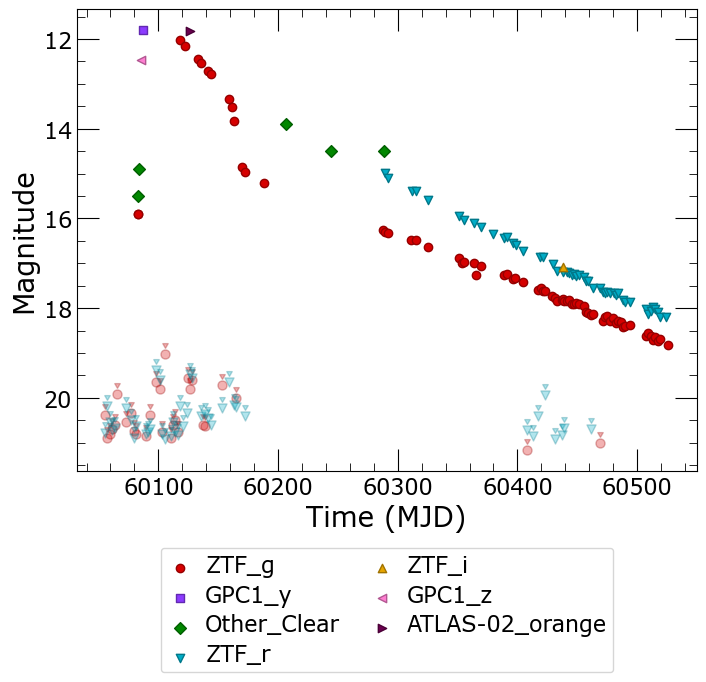

In [21]:
# plot all photometry
import matplotlib.pyplot as plt
from snapi import Formatter

formatter = Formatter() # initialize formatter
fig, ax = plt.subplots(figsize=(8, 6))
ixf_transient.photometry.plot(ax, formatter=formatter) # the .plot() function 
formatter.make_plot_pretty(ax) # make the plot pretty
formatter.add_legend(ax, ncols=2) # add a legend
plt.show()

Looks pretty good! Now let's see the same plot in flux space.

SNAPI photometry is extremely useful in that upon creation or modification, it will automatically fill in fluxes or magnitudes if one is provided along with zeropoints. That means that, for example, we can import only sets of magnitudes and zeropoints and automatically be able to plot fluxes. There is also the option use calibrated fluxes using the LightCurve's .calibrate() function, but we will not use that here.

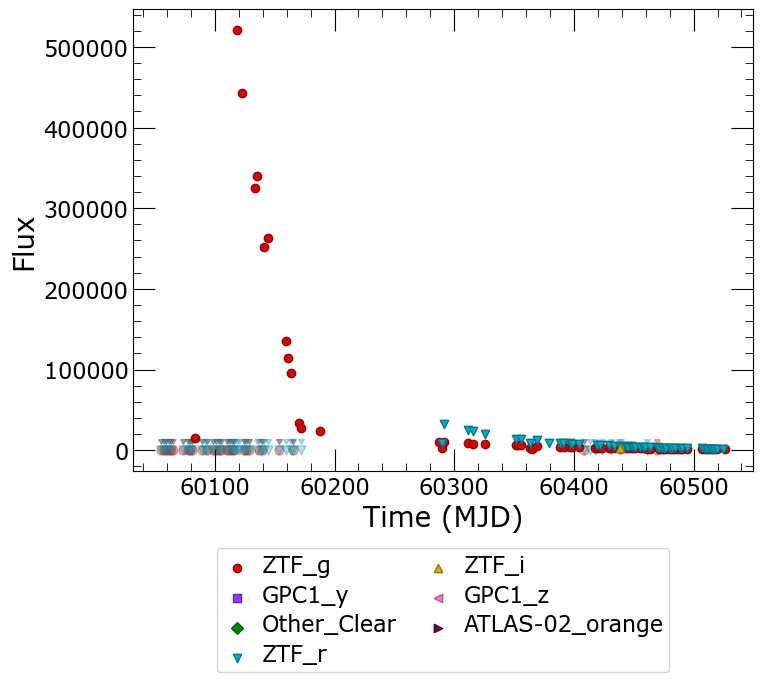

In [22]:
# can also plot in flux space
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
ixf_transient.photometry.plot(ax, mags=False)
formatter.add_legend(ax, ncols=2)
formatter.make_plot_pretty(ax)
plt.show()

Because a Photometry object consists of a collection of LightCurve objects, we can instead plot each LightCurve individually by calling "lc.plot()" for each lc in transient.photometry.light_curves:

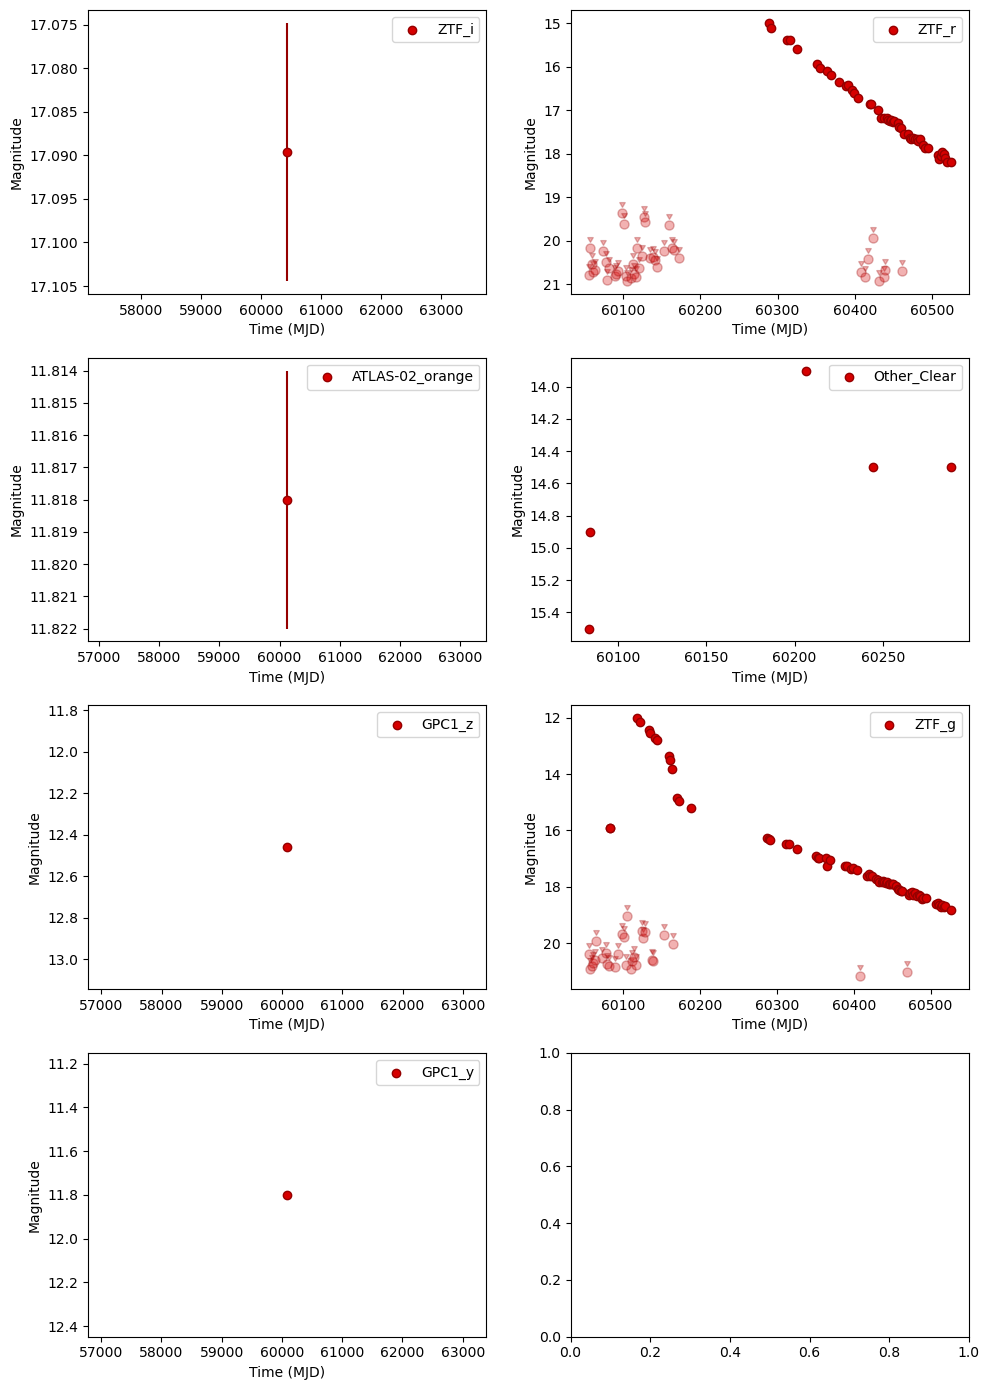

In [23]:
from snapi import Formatter
import matplotlib.pyplot as plt

# can also plot each LC individually
formatter = Formatter()
fig, axes = plt.subplots(4, 2, figsize=(10, 14))
for i, lc in enumerate(ixf_transient.photometry.light_curves):
    ax = axes.flatten()[i]
    lc.plot(ax, formatter)
    ax.legend(loc="best")
    # formatter.make_plot_pretty(ax)
plt.tight_layout()
plt.show()

Now we can move on to spectra. Through TNS, we automatically imported a series of spectra for 2023ixf. Let's plot these in a few different ways: first overlaying all spectra, then by introducing a vertical offset. The vertical offsets are automatically calculated to prevent any line overlaps (which could look strange for very noisy spectra).

In the second example, we also overlay spectral lines on the spectra. While we overlay "He I", there is an entire collection of lines we can overlay which can be found in the "src/constants/ion_lines.py" file.

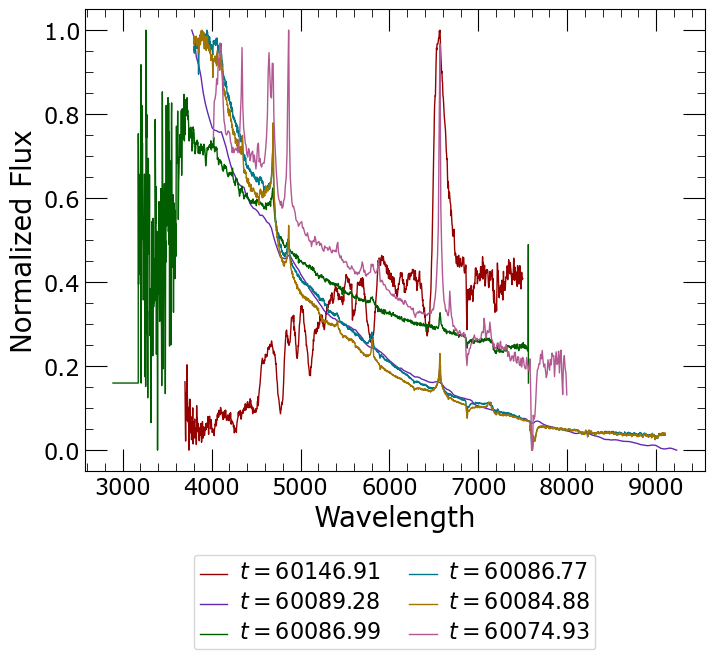

In [24]:
import matplotlib.pyplot as plt
from snapi import Formatter

spectra = ixf_transient.spectroscopy
formatter = Formatter(linewidth=1)  # good for spectra
fig, ax = plt.subplots(figsize=(8, 6))
spectra.plot(ax, formatter)
formatter.make_plot_pretty(ax)
formatter.add_legend(ax, ncols=2)
plt.show()

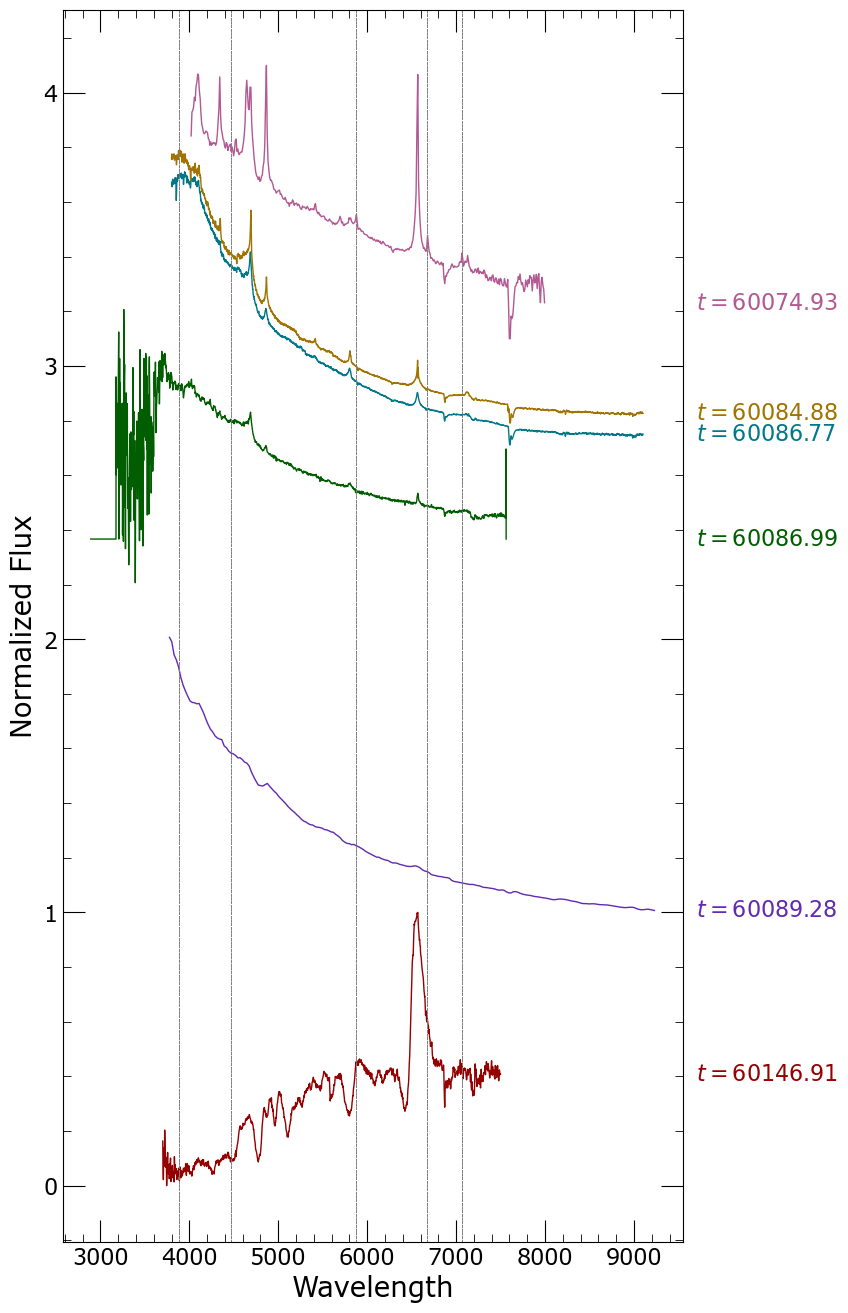

In [25]:
import matplotlib.pyplot as plt
from snapi import Formatter

spectra = ixf_transient.spectroscopy
formatter = Formatter(linewidth=1)
fig, ax = plt.subplots(figsize=(8, 16))
spectra.plot(ax, formatter, vertical_offsets=True, overlay_lines=["He I"])
formatter.make_plot_pretty(ax)
plt.show()

Finally, we should save this transient so we can retrieve information later without re-querying. Thankfully, SNAPI has an extremely simple save/load functionality based around HDF5 files:

In [26]:
import os
ixf_transient_path = os.path.abspath("data/ixf_transient.hdf5")
ixf_transient.save(ixf_transient_path)

## Example 2: Querying by RA/dec
Previously, I briefly mentioned that one can query transient information using coordinates instead of name. Whereas the previous example queried 2023ixf by IAU name, here we use RA/DEC to cross-match a dataset of DECAM DDF "likely-real" candidates: https://arxiv.org/abs/2211.09202 

In [27]:
# import DECAM data
import pandas as pd
import numpy as np

decam_fn = "data/candidates.dat"
decam_df = pd.read_table(
    decam_fn,
    sep=r"\s+",
    comment="#",
    names=["field", "id", "ra", "dec", "n_obs", "mean_rb"],
    usecols=np.arange(6),
)
print(decam_df.head())

    field        id          ra       dec  n_obs   mean_rb
0  COSMOS   DC21nzd  148.517236  1.113035     94  0.654793
1  COSMOS  DC21dedx  148.514108  1.132090     46  0.574055
2  COSMOS   DC21tcr  148.549066  1.105873     22  0.425603
3  COSMOS  DC21bjcs  148.610633  1.056165     20  0.668960
4  COSMOS  DC21benq  148.612204  1.072722     33  0.432105


There are two sets of fields in the DECAM deep-drilling fields: 3 fields that overlap with COSMOS (declination ~1-4 degrees), and 2 fields at lower declination (-45 -> -42 deg). Let's display them:

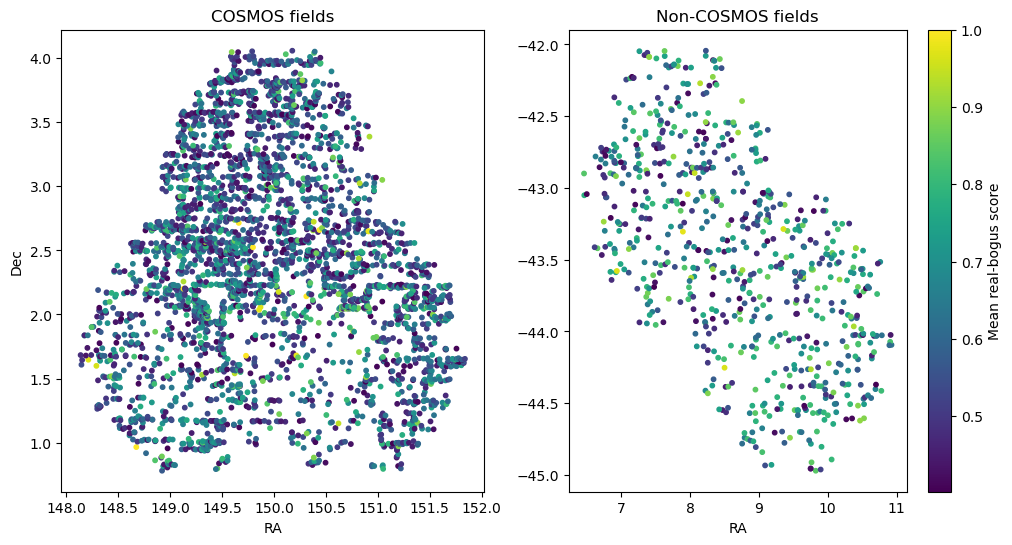

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# plot COSMOS ra/dec distribution
cosmos_ddf = decam_df[decam_df["field"] == "COSMOS"]
l = ax[0].scatter(
    cosmos_ddf["ra"], cosmos_ddf["dec"], c=cosmos_ddf["mean_rb"], cmap="viridis", vmax=1.0, s=10
)
ax[0].set_title("COSMOS fields")

# plot non-COSMOS fields
non_cosmos_ddf = decam_df[decam_df["field"] != "COSMOS"]
l2 = ax[1].scatter(
    non_cosmos_ddf["ra"], non_cosmos_ddf["dec"], c=non_cosmos_ddf["mean_rb"], cmap="viridis", vmax=1.0, s=10
)
ax[1].set_title("Non-COSMOS fields")
fig.colorbar(label="Mean real-bogus score", mappable=l2)

ax[0].set_xlabel("RA")
ax[1].set_xlabel("RA")
ax[0].set_ylabel("Dec")

plt.show()

As we can see, all events in this dataset have a mean real-bogus score above 0.4, which is the "probably-real" threshhold according to the paper, so we keep all events for cross-matching.

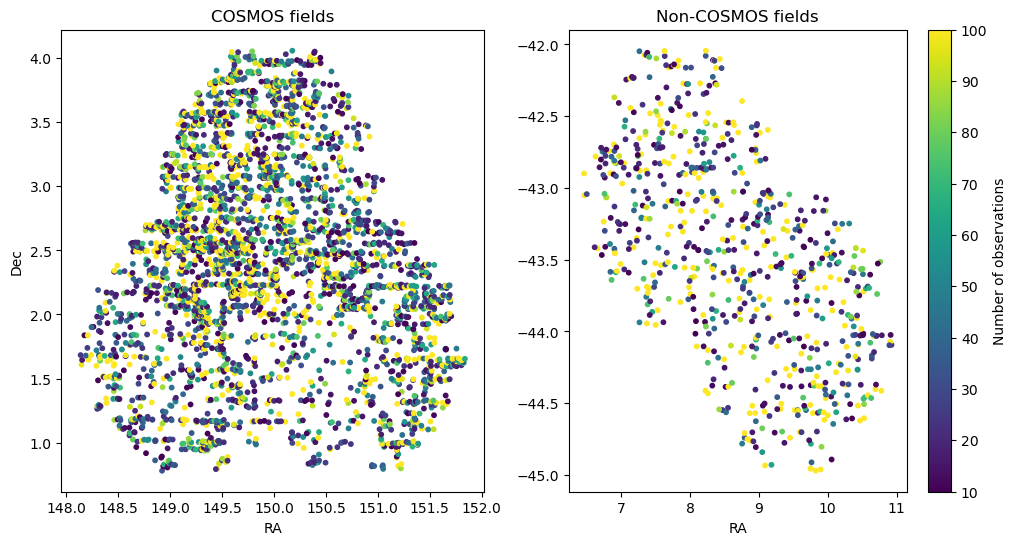

In [14]:
# now colorbar by number of observations

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# plot COSMOS ra/dec distribution
cosmos_ddf = decam_df[decam_df["field"] == "COSMOS"]
l = ax[0].scatter(cosmos_ddf["ra"], cosmos_ddf["dec"], c=cosmos_ddf["n_obs"], cmap="viridis", vmax=100, s=10)
ax[0].set_title("COSMOS fields")

# plot non-COSMOS fields
non_cosmos_ddf = decam_df[decam_df["field"] != "COSMOS"]
l2 = ax[1].scatter(
    non_cosmos_ddf["ra"], non_cosmos_ddf["dec"], c=non_cosmos_ddf["n_obs"], cmap="viridis", vmax=100, s=10
)
ax[1].set_title("Non-COSMOS fields")
fig.colorbar(label="Number of observations", mappable=l2)

ax[0].set_xlabel("RA")
ax[1].set_xlabel("RA")
ax[0].set_ylabel("Dec")

plt.show()

Many events (those in yellow) have over 100 observations; they are probably AGN or very long-duration TDEs/SNe.

Because northern sky telescopes like ZTF and Pan-STARRS have a minimum declination > ~-30 degrees, we expect potential TNS cross-matches within only the COSMOS fields. Let's use SNAPI to make this cross-matching simple. The series of steps for each entry are:

(1) Create a Transient object with the DECam identifier (NOT IAU) and the RA and declination values. Because these are floats in degree, we need to add units using astropy before initialization.

(2) Because we don't have a ZTF or IAU identifier, we won't be able to query by name from TNS or ALeRCE. However, we can use the exact same command "query_transient()" and SNAPI will automatically try a cone search. NOTE: here we use the "local=True" keyword. This, instead of querying TNS directly, consults a local CSV containing all TNS entries as of time of creation. While no photometry or spectroscopy are saved locally, this is the much faster option for a loop involving thousands of TNS queries, which we are doing here.

(3) If a match was found, then transient's "id" field will automatically be replaced by the IAU name, and the DECam identifier will be moved to "internal_names". Therefore, we check whether the internal_names field is non-empty and if so, add the transient to our collection of successfully cross-matched objects.

In [15]:
import astropy.units as u
from snapi import Transient
from snapi.query_agents import TNSQueryAgent

tns_query_agent = TNSQueryAgent()
cross_matched_transients = set()


for i, row in decam_df.iterrows():
    if i % 500 == 0:
        print(f"Processing transient {i}/{len(decam_df)}")
    decam_transient = Transient(
        iid=row["id"],
        ra=row["ra"] * u.deg,  # pylint: disable=no-member
        dec=row["dec"] * u.deg,  # pylint: disable=no-member
    )

    # query TNS
    query_results, _ = tns_query_agent.query_transient(decam_transient, local=True)
    for query_result in query_results:
        decam_transient.ingest_query_info(query_result.to_dict())

    # check if IAU name found
    if decam_transient.internal_names:  # check if non-empty
        print(f"Matched {row['id']} with TNS object {decam_transient.spec_class} {decam_transient.id}")
        cross_matched_transients.add(decam_transient)

Processing transient 0/4383
Processing transient 500/4383
Processing transient 1000/4383
Processing transient 1500/4383
Matched DC21mux with TNS object nan 2020ltr
Processing transient 2000/4383
Matched DC21kuk with TNS object nan 2021aewz
Processing transient 2500/4383
Matched DC21dqik with TNS object nan 2021nfp
Matched DC21fyx with TNS object nan 2019tzk
Matched DC21crhk with TNS object nan 2019tzk
Processing transient 3000/4383
Processing transient 3500/4383
Matched DC21cxou with TNS object nan 2021aiay
Matched DC22eawkf with TNS object nan 2022km
Processing transient 4000/4383
Matched DC21kkth with TNS object nan 2021qvu


We see we've successfully crossmatched a handful of DDF events with TNS! Let's save the Transient objects so we don't have to rerun that loop every time.

In [16]:
# save matching transients
for transient in cross_matched_transients:
    transient.save(f"data/ddf_transient_{transient.id}.hdf5")

Now that we've reduced the dataset down to a small number, let's run a full query loop on each event:

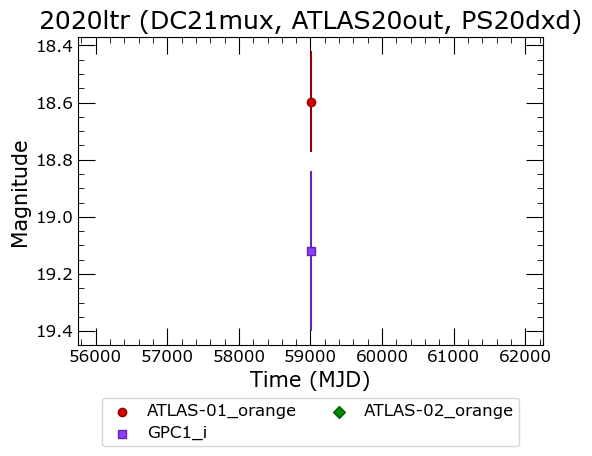

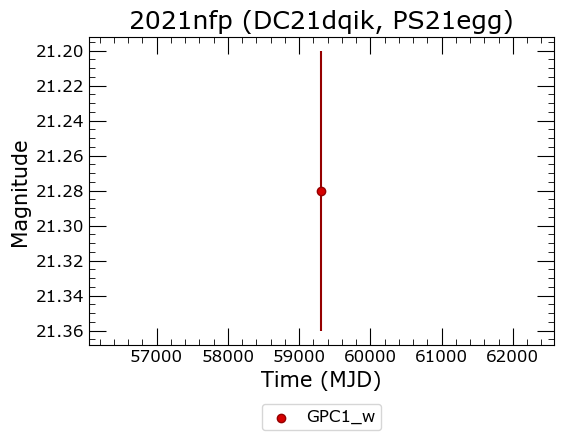

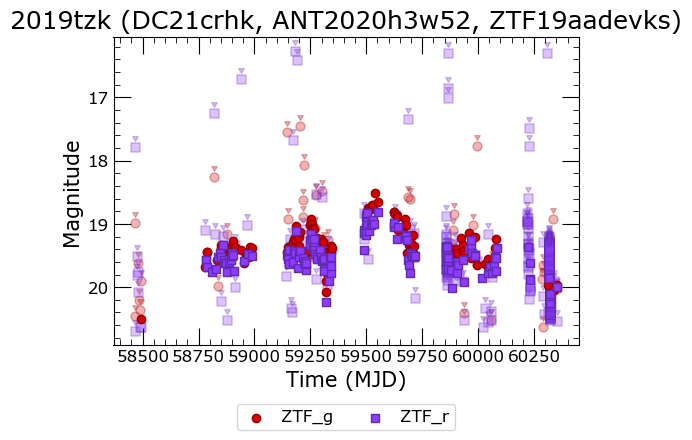

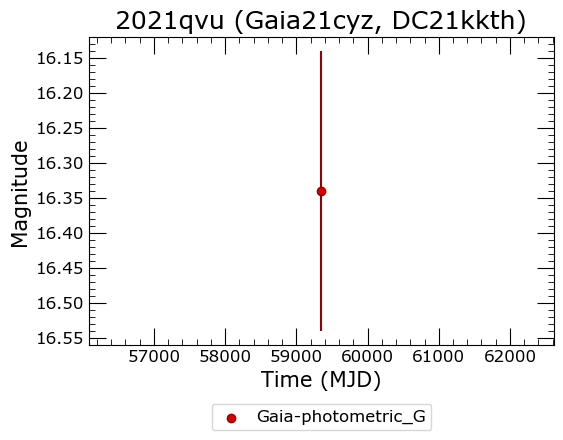

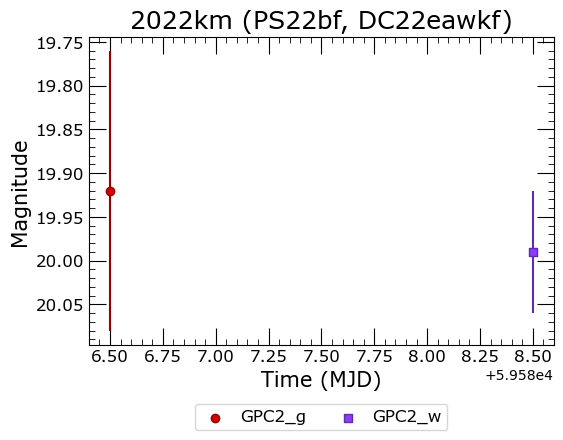

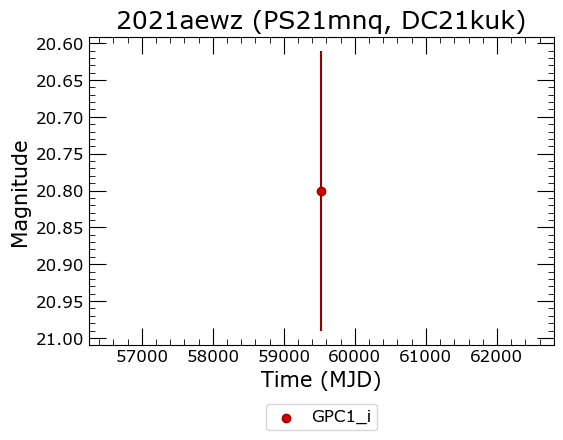

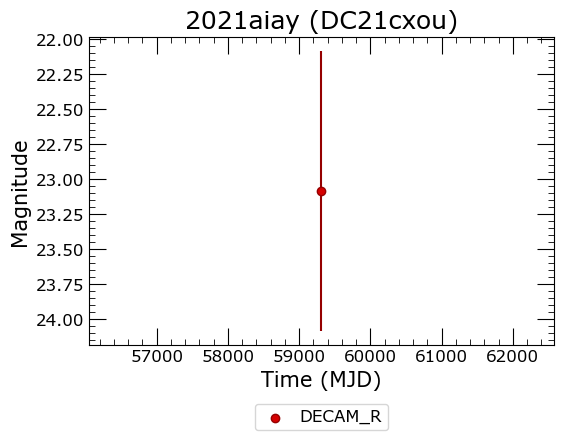

In [1]:
import glob
import matplotlib.pyplot as plt
from snapi.query_agents import TNSQueryAgent, ANTARESQueryAgent
from snapi import Transient, Formatter

tns_agent = TNSQueryAgent()
antares_agent = ANTARESQueryAgent()
formatter = Formatter()

# ensure we can load the transients
for f in glob.glob("data/ddf_transient_*.hdf5"):
    transient = Transient.load(f)

    # small internal names fix
    internal_names = set(transient.internal_names)
    if "nan" in transient.internal_names:
        internal_names.remove("nan")
    transient.internal_names = internal_names

    for agent in [tns_agent, antares_agent]:
        query_results, _ = agent.query_transient(transient)
        for query_result in query_results:
            transient.ingest_query_info(query_result.to_dict())

    fig, ax = plt.subplots(figsize=(6, 4))
    transient.photometry.plot(ax)
    ax.set_title(f"{transient.id} ({", ".join(transient.internal_names)})")
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax, ncols=2)
    plt.show()

    # now re-save
    transient.save(f"data/ddf_transient2_{transient.id}.hdf5")

2019tzk looks like an AGN, and has significant ZTF data. Let's overlay our DECAM photometry by adding it to the Transient object and re-plotting.

           flux     fluxerr      magzp filter       meanmjd
0   6624.358546  107.150984  28.974368      g  59297.009363
1   7139.620681   90.695119  28.998356      g  59297.058879
2   7323.181904   92.144569  28.998950      g  59297.133525
3   6518.646342  297.287396  29.591250      r  59301.019212
4  30930.549736  308.930259  30.280443      i  59297.148954


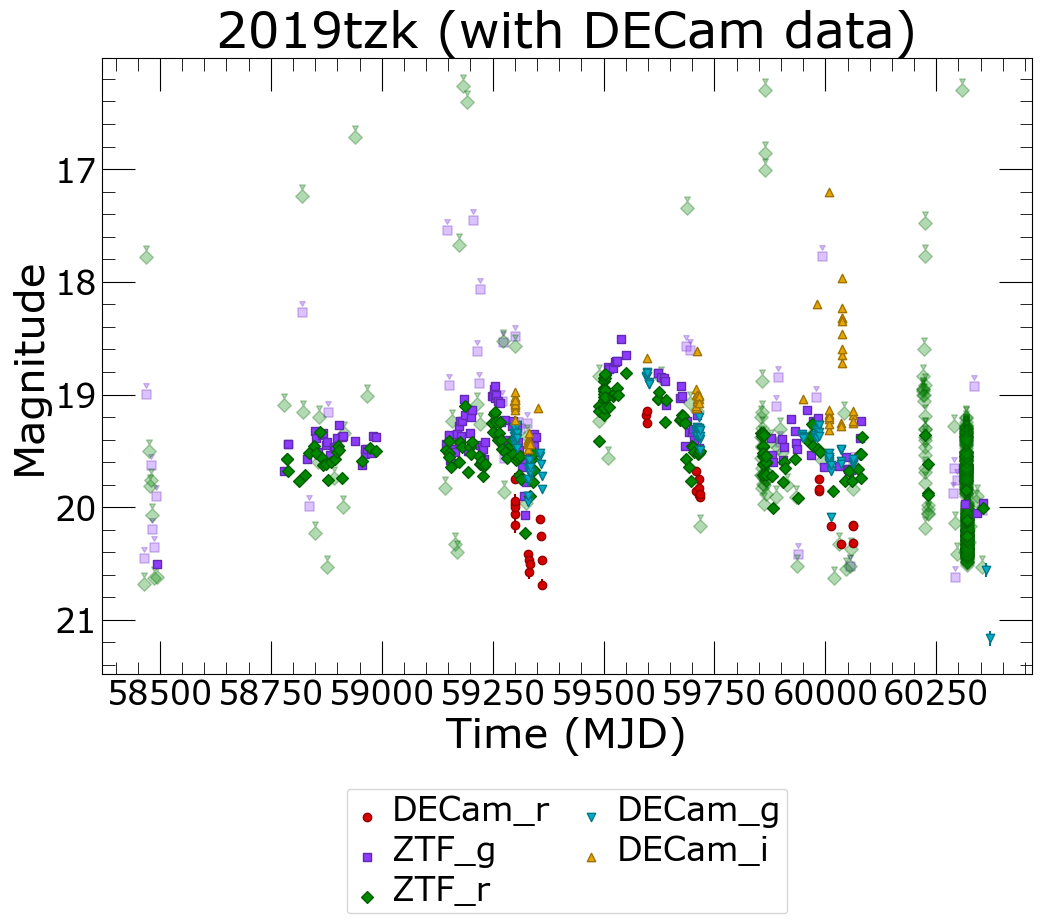

Total observations: 481


In [4]:
import pandas as pd
import numpy as np
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy import units as u
import matplotlib.pyplot as plt

from snapi import LightCurve, Filter, Formatter, Transient
import os

transient_2019tzk = Transient.load("data/ddf_transient2_2019tzk.hdf5")
formatter = Formatter()

# photometry file for DECam
observations_df = pd.read_csv(
    "data/DC21fyx.csv",
    usecols=[4, 5, 6, 7, 8],
    header=0,
)
print(observations_df.head())

for band in np.unique(observations_df["filter"]): # we save each band separately as a LightCurve object
    band_df = observations_df[observations_df["filter"] == band]
    filt = Filter( # first we create a Filter object for each DECam filter
        instrument="DECam",
        band=band,
        center=np.nan * u.AA,
    )
    time_mjds = Time(band_df["meanmjd"].values, format="mjd")
    lc = LightCurve(
        times=time_mjds,
        fluxes=band_df["flux"].values,
        flux_errs=band_df["fluxerr"].values,
        zpts=band_df["magzp"].values,
        filt=filt, # we pass the Filter object to the LightCurve object
    )
    transient_2019tzk.photometry.add_lightcurve(lc)

fig, ax = plt.subplots(figsize=(12, 8))
transient_2019tzk.photometry.plot(ax)
ax.set_title("2019tzk (with DECam data)")
formatter.make_plot_pretty(ax)
formatter.add_legend(ax, ncols=2)
plt.show()

print(f"Total observations: {len(transient_2019tzk.photometry.detections)}")


transient_2019tzk_path = os.path.abspath("data/ddf_transientdecam_2019tzk.hdf5")
transient_2019tzk.save(transient_2019tzk_path)

We see here that the DECam and ZTF data align very well, capturing the same stochastic behavior of the AGN. However, we note that above, there were TWO DECam events that mapped to 2019tzk, the other being DC21crhk. Let's add that data in as well. Because this light curve has the same filter as the previous DECam light curve, it will actually merge observations with the existing LightCurve for that filter, instead of creating a new LightCurve:

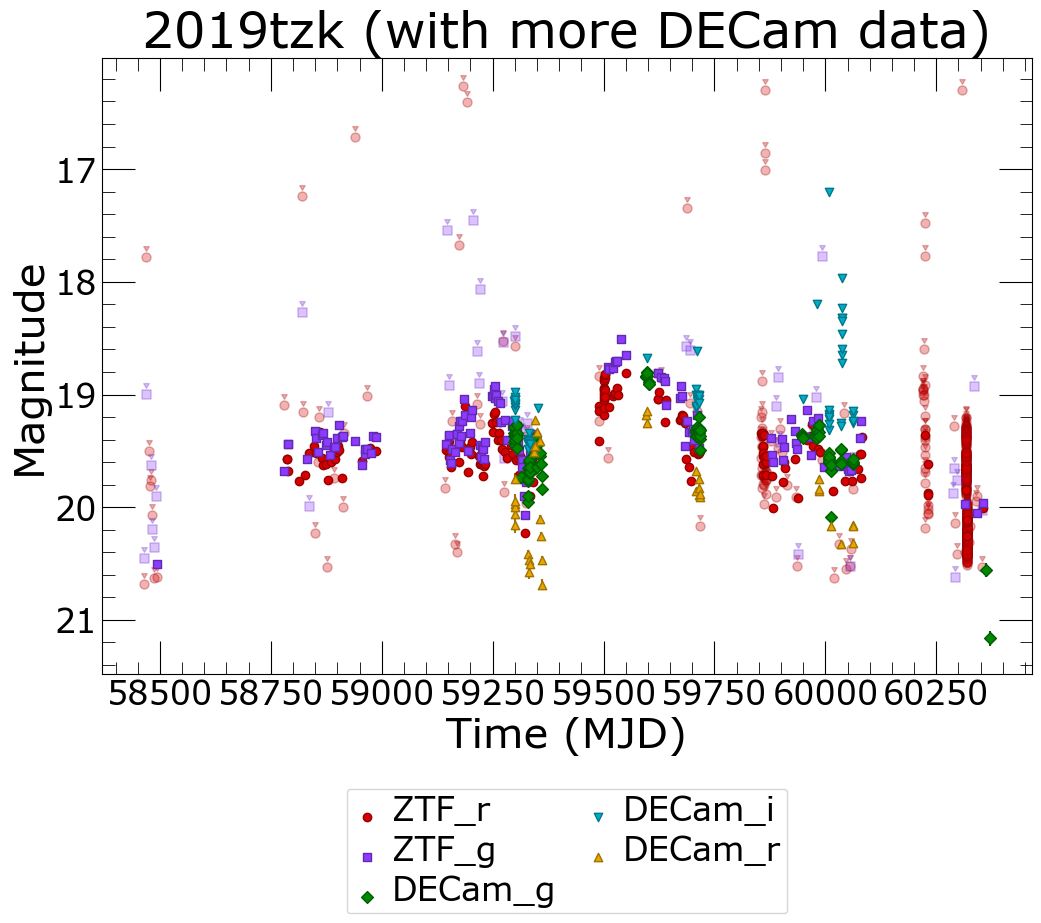

Total observations: 493


In [5]:
import pandas as pd
import numpy as np
from astropy.time import Time
from astropy import units as u
import matplotlib.pyplot as plt

from snapi import LightCurve, Filter, Formatter, Transient
import os

transient_2019tzk = Transient.load("data/ddf_transientdecam_2019tzk.hdf5")
formatter = Formatter()

observations_df = pd.read_table(
    "data/DC21crhk.csv",
    usecols=[5, 6, 7, 8],
    names=["meanmjd", "filter", "mag", "magerr"],
    sep=r"\s+",
)

for band in np.unique(observations_df["filter"]):
    band_df = observations_df[observations_df["filter"] == band]
    filt = Filter(
        instrument="DECam",
        band=band,
        center=np.nan * u.AA,
    )
    time_mjds = Time(band_df["meanmjd"].values, format="mjd")
    lc = LightCurve(times=time_mjds, mags=band_df["mag"].values, mag_errs=band_df["magerr"].values, filt=filt)
    transient_2019tzk.photometry.add_lightcurve(lc)

fig, ax = plt.subplots(figsize=(12, 8))
transient_2019tzk.photometry.plot(ax)
ax.set_title("2019tzk (with more DECam data)")
formatter.make_plot_pretty(ax)
formatter.add_legend(ax, ncols=2)
plt.show()

print(f"Total observations: {len(transient_2019tzk.photometry.detections)}")
transient_2019tzk_path = os.path.abspath("data/ddf_transientdecam_2019tzk.hdf5")
transient_2019tzk.save(transient_2019tzk_path)

Only 11 observations were added, so not much difference is noted!

## Example 3: Fitting Photometry using the Sampler class.

After importing and saving photometry, we would like to extract information from that photometry for downstream tasks. One way we can do so is by fitting the light curves in photometry to a specific model. In SNAPI, we accomplish this by defining a subclass of the Sampler class.

The Sampler class actually inherits from scikit-learn's BaseEstimator class, which means it has the standard .fit()/.predict()/.score() framework we see in all scikit-learn classifiers and regressors. For the .fit() function, we provide data to fit, and the .predict() function gives us predicted fluxes/magnitudes for new inputs. For the samplers used in this demo, .score() returns the reduced chi-squared of the best fits. In addition, SNAPI's Sampler has custom-defined .fit_photometry() and .predict_photometry() functions, which allows us to directly feed in a Photometry object and return sets of fit parameters.

Fit parameters are stored in a SamplingResult object. The main attributes are:

* 'fit_parameters': pandas DataFrame containing equally-weighted posterior samples of each model parameter.

* 'score': the median reduced chi-squared of all fits from 'fit_parameters'


Like other SNAPI objects, SamplingResult objects can be saved/loaded using .save() and .load(), respectively. A SamplingResult can be linked to a Sampler using .load_result(), which will run the SamplingResult's load() function and assign it to the Sampler's "result" attribute.

Superphot+'s nested sampler is implemented as a subclass of Sampler, so we can integrate it seamlessly into our SNAPI framework. Let's test it out on 2023ixf:

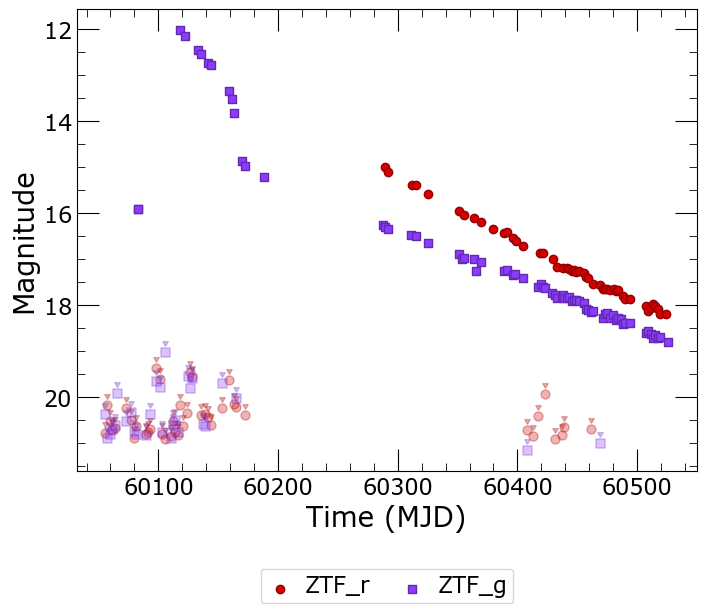

In [28]:
# for this example, we'll be using ZTF photometry from 2023ixf.
from snapi import Transient
import matplotlib.pyplot as plt
from snapi import Formatter

formatter = Formatter()
ixf_transient = Transient.load("data/ixf_transient.hdf5")
ixf_photometry = ixf_transient.photometry
ztf_photometry = ixf_photometry.filter({"ZTF_g", "ZTF_r"}) # filter for ZTF g and r bands

fig, ax = plt.subplots(figsize=(8, 6))
ztf_photometry.plot(ax, formatter=formatter)
formatter.make_plot_pretty(ax)
formatter.add_legend(ax, ncols=2)
plt.show()

Note that SNAPI's fit_photometry() and predict_photometry() functions will automatically phase and normalize the photometry. This means that one has to then rescale the fit by the peak flux (or magnitude) to arrive back at original amplitudes.

In [35]:
# first make sure to install Superphot+ from source
from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.surveys.surveys import Survey
import warnings

from snapi import Photometry

warnings.filterwarnings("ignore")

priors = Survey.ZTF().priors

dynesty_sampler = DynestySampler(
    priors,
    random_state=42
)
# small fix
new_lcs = []
for lc in ztf_photometry.light_curves:
    lc.flux_errors = 0.1 * lc.fluxes
    new_lcs.append(lc)
ztf_photometry = Photometry(new_lcs)
print(ztf_photometry.detections)
dynesty_sampler.fit_photometry(ztf_photometry)
s_result = dynesty_sampler.result
print(s_result.score)
print(s_result.fit_parameters.head())


        time            flux        flux_err   ... filt_centers filt_widths
------------------- ------------ ------------- ... ------------ -----------
-123.64707946777344          nan           nan ...          nan         nan
-121.64707946777344          nan           nan ...          nan         nan
-121.57408142089844   0.02823579   0.002823579 ...          nan         nan
 -86.63929748535156          1.0           0.1 ...          nan         nan
 -82.59315490722656    0.8503541   0.085035406 ...          nan         nan
 -71.57209777832031    0.6240227   0.062402274 ...          nan         nan
 -69.65557098388672    0.6516286    0.06516286 ...          nan         nan
 -63.67125701904297   0.48261458    0.04826146 ...          nan         nan
-60.638084411621094    0.5048942   0.050489422 ...          nan         nan
  -45.6124382019043   0.26013586   0.026013587 ...          nan         nan
                ...          ...           ... ...          ...         ...
  308.341705

AttributeError: 'NoneType' object has no attribute 'score'

Now, let's plot the fits!

In [ ]:
import matplotlib.pyplot as plt
from snapi import Formatter

fig, ax = plt.subplots(figsize=(8, 6))
formatter = Formatter()

dynesty_sampler.plot_fit(ax=ax, formatter=formatter, photometry=ztf_photometry) # plot fit
ztf_photometry.plot(ax, formatter, mags=False) # plot data

ax.set_title(f'{transient.id}: {dynesty_sampler.result.score:.2f}')
formatter.make_plot_pretty(ax)
formatter.add_legend(ax, ncols=2)
plt.show()

We can now fit and plot fitted transients in just a few lines!

This is where the demo ends for now, but SNAPI is expected to gain many functionalities in the next few months. This includes:

* Host galaxy querying and addition to transient information. Also includes incorporating host redshifts and displaying postage stamps.

* Simple spectra reduction + pre-processing.

* Conversion of photometry into arrays for machine learning applications.

* Abstract class for Classifiers which also follow the scikit-learn BaseEstimator framework.